# Chapter 5.4: Visualizing what convnets learn

In many applications, deep learning models are black boxes - NOT with conv nets though! With conv nets you can visualize what the algorithm is learning, so we'll play around with visualization.

We'll cover these 3 visualization techniques

- Visualizing intermediate convnet outputs (intermediate activations) —Useful for understanding how successive convnet layers transform their input, and for get- ting a first idea of the meaning of individual convnet filters.
- Visualizing convnets filters—Useful for understanding precisely what visual pat- tern or concept each filter in a convnet is receptive to.
- Visualizing heatmaps of class activation in an image—Useful for understanding which parts of an image were identified as belonging to a given class, thus allow- ing you to localize objects in images.

In [1]:
# Visualizing intermediate activations
# There are 32 channels, so we'll need to see 32 different feature images

# load the model you trained earlier! Cool huh?
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 128)       0      

(1, 150, 150, 3)


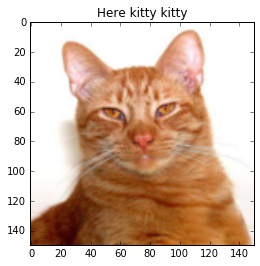

In [2]:
# now take a sample picture of a cat (any picutre works)
from keras.preprocessing import image 
import numpy as np

img_path = './cats_and_dogs_small/test/cats/cat.1612.jpg'

# preprocess image as 4D tensor
# Remember that the model was trained on inputs that were preprocessed this way.
# So it's important to feed the model data in the way it expects

img = image.load_img(img_path, target_size=(150, 150)) 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

print(img_tensor.shape)

import matplotlib.pyplot as plt
plt.title('Here kitty kitty')
plt.imshow(img_tensor[0])
plt.show()


So the activation is 148 x 148 and has 32 filters


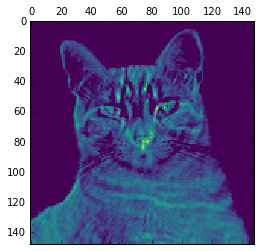

2nd channel seems to encode vertical edge vectors


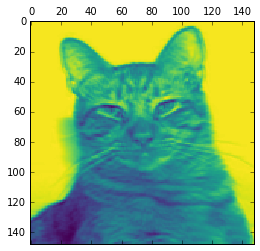

3rd channel seems to encode background


In [3]:
# Instantiating a model from an input tensor and a list of output tensors

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] 
# gets outputs of top 8 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# creates model that will return these outputs given some input model


# run model in predict mode
activations = activation_model.predict(img_tensor)
#Returns a list of five Numpy arrays: one array per layer activation

# visualize
first_layer_activation = activations[0]
print('So the activation is %d x %d and has %d filters' % 
      (first_layer_activation.shape[1], 
       first_layer_activation.shape[2],
      first_layer_activation.shape[3]))

plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()
print('2nd channel seems to encode vertical edge vectors')
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()
print('3rd channel seems to encode background')

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


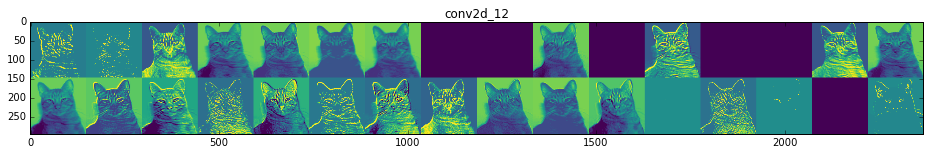

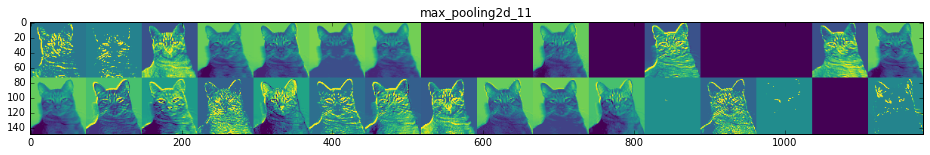

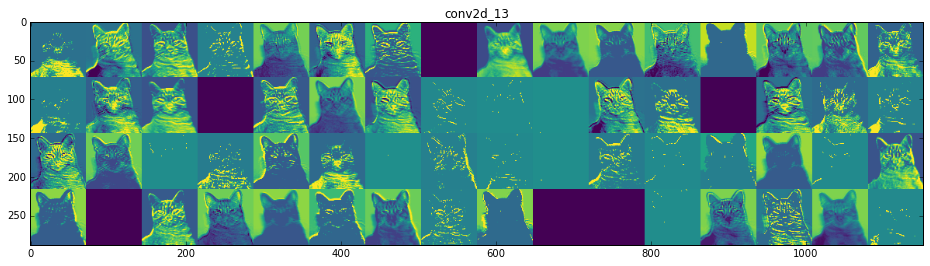

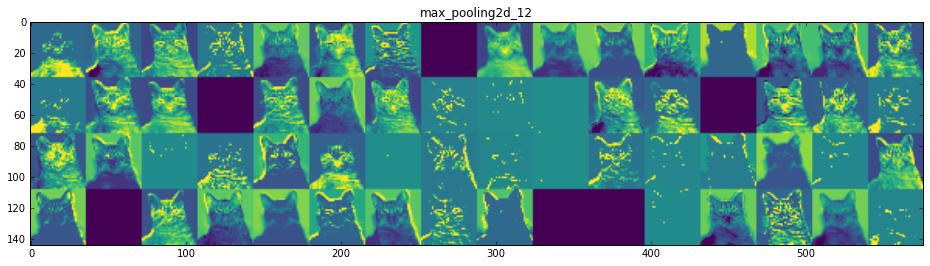

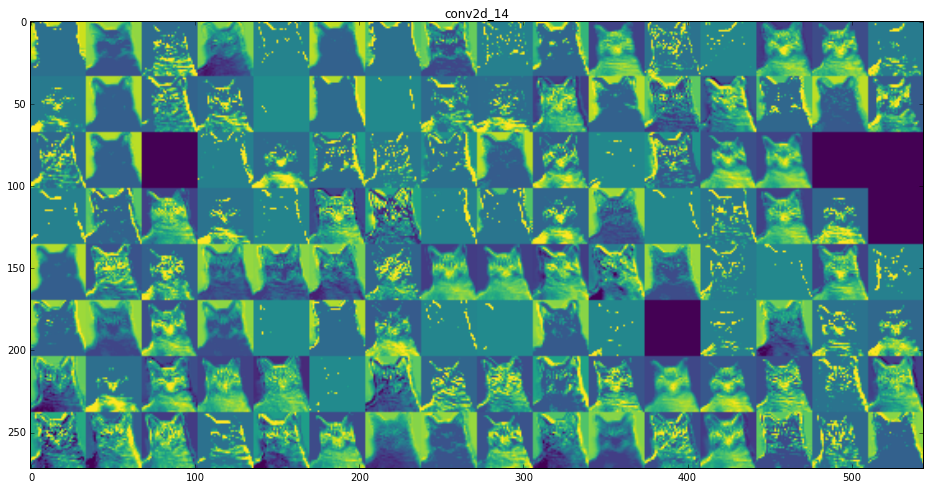

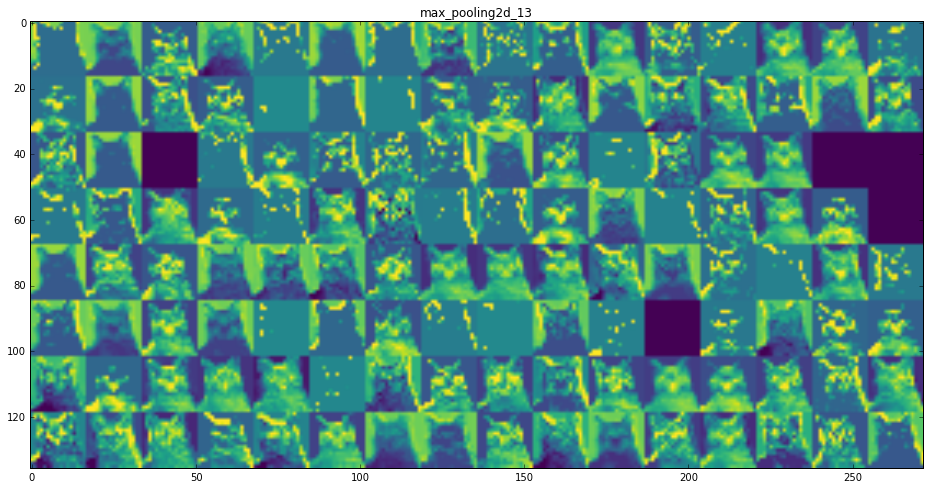

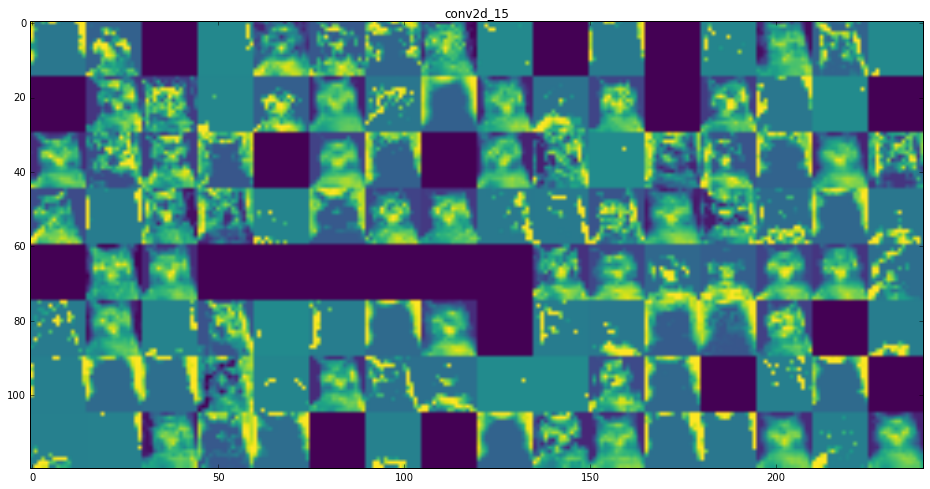

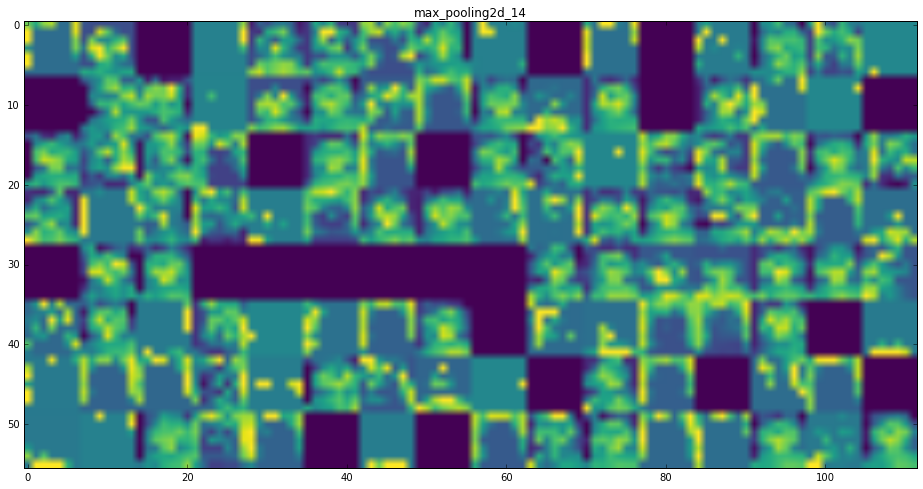

In [4]:

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
#Names of the layers, so you can have them as part of your plot
#Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    #Number of features in the feature map
    #Tiles the activation channels in this matrix
    #Post-processes the feature to make it visually palatable
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    #Tiles each filter into a big horizontal grid

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

There are a few things to note here:
- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go higher, the activations become increasingly abstract and less visually
interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

## Visualizing convnet filters

This part is cool! It's basically the dreamy images you see in hyped articled online. But more importantly, it shows you the types of patterns convnet filters 'see'.

We're going to test which pattern the filter responds most strongly to. The steps are simple:

1. Start with a blank image
2. build loss function that maximizes value of a filter in a layer
3. use SGD to adjust values of image to maximize the filter response

We'll work with the VGG16 we used previously

In [5]:
# Defining the loss tensor for filter visualization

from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
              include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# Obtaining the gradient of the loss with regard to the input

grads = K.gradients(loss, model.input)[0]
#The call to gradients returns a list of tensors (of size 1 in this case). 
#Hence, you keep only the first element— which is a tensor.
  
# normalize gradient tensor by dividing by its L2 norm, this makes all gradient tensor have same range of values
# we want to compare apples to apples


grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
#Add 1e–5 before dividing to avoid accidentally dividing by 0.

# Fetching Numpy output values given Numpy input values

# iterate takes a Numpy tensor (as a list of tensors of size 1) and returns a list of
#two Numpy tensors: the loss value and the gradient value.
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# maximize loss via stochastic gradient descent

# start from gray image with noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.


step = 1.
# take 40 steps
for i in range(40):
    #compute the loss
    loss_value, grads_value = iterate([input_img_data])
    #adjust input image in direction that maximizes the loss
    input_img_data += grads_value * step

# next we need to (a) normalize the image and then (b) map it back to RGB 255 to see it

def deprocess_image(x):
    # mean 0 std .1
    x-=x.mean()
    x/=(x.std()+1e-5)
    x+=.1
    
    # clip to [0,1] interval
    x+=0.5
    x=np.clip(x,0,1)
    
    # conver back to RGB array
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x



In [20]:
# Function to generate filter visualizations

# progress
from tqdm import tqdm

def deprocess_image(x):
    # mean 0 std .1
    x-=x.mean()
    x/=(x.std()+1e-5)
    x+=.1
    
    # clip to [0,1] interval
    x+=0.5
    x=np.clip(x,0,1)
    
    # conver back to RGB array
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x


#build loss func that maximizes activation of the nth filter of the layer
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # compute gradient of input picture
    
    grads = K.gradients(loss,model.input)[0]
    
    # normalize gradient
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # return loss and gradient
    
    iterate = K.function([model.input], [loss, grads])
    
    # gray noisy input picture
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    # run gradient descent for 20 steps for speed
    for i in range(99):
        #print('step %d',i)
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)
          
        

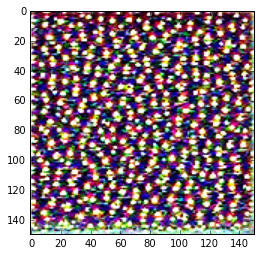

In [10]:
#check filter 0 in block 3
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

100%|██████████| 99/99 [00:24<00:00,  4.05it/s]


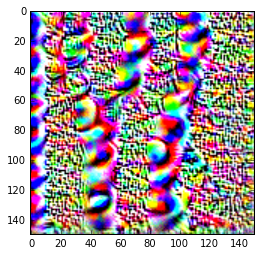

In [23]:
# check block 4 filter 2
plt.imshow(generate_pattern('block4_conv1', 2))
plt.show()

100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


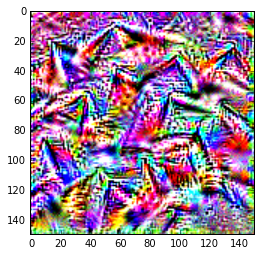

In [24]:
# check block 5 conv 2 filter 0
# starts getting crazy here
plt.imshow(generate_pattern('block5_conv2', 0))
plt.show()

100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


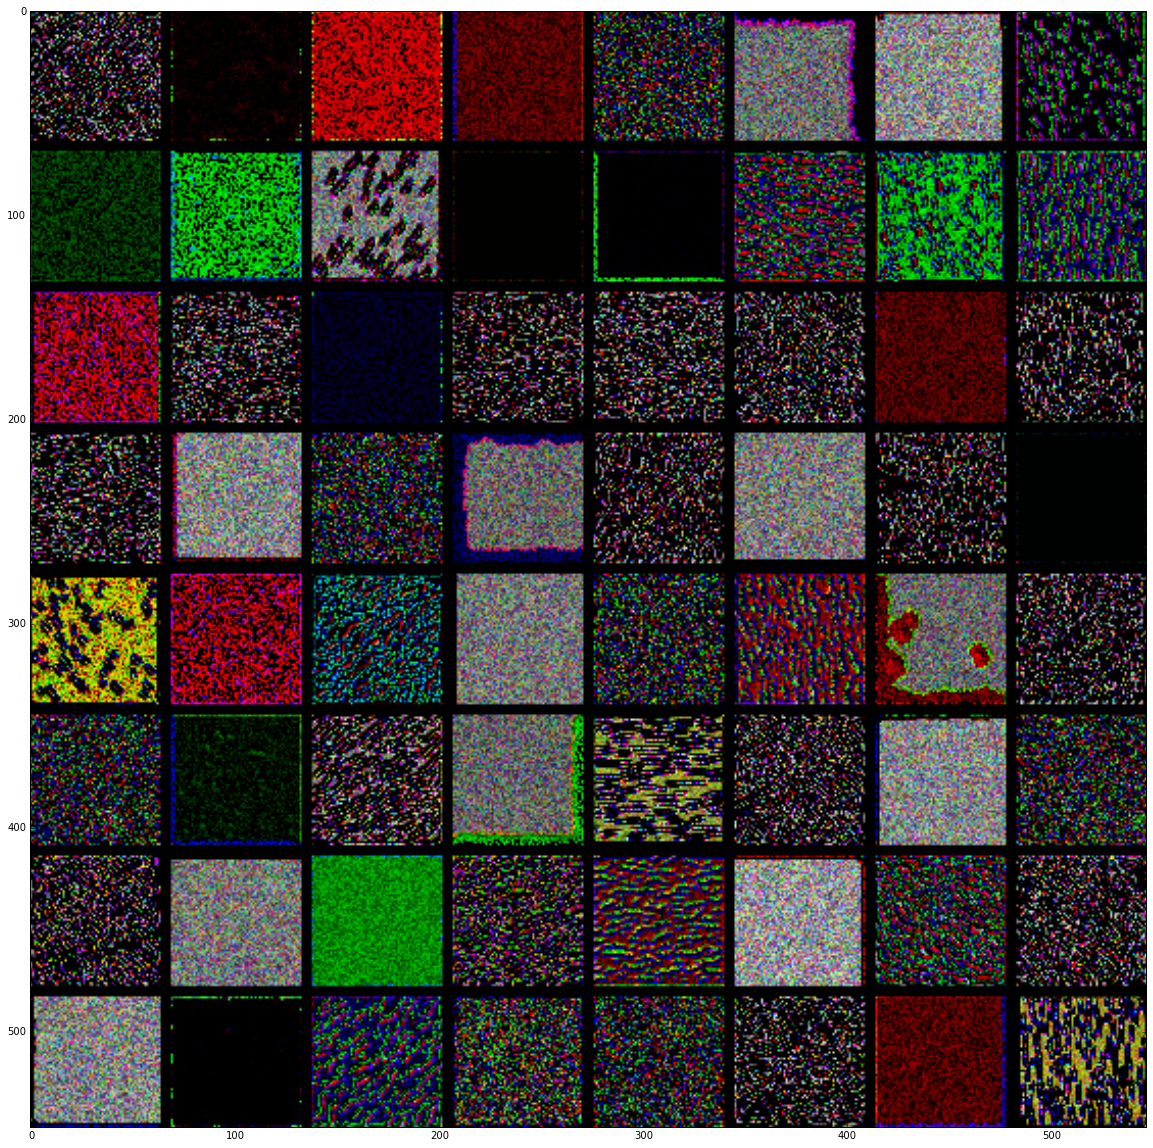

In [11]:
# the above pattern shows that the filter responds to a quasi-periodic pattern

# Now we can do this this for every filter in the layer

# Generating a grid of all filter response patterns in a layer

layer_name = 'block1_conv1'
size = 64
margin = 5
#Empty (black) image to store results
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in tqdm(range(8)): 
    #Iterates over the rows of the results grid
    for j in range(8): 
        #Iterates over the columns of the results grid
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        #Generates the pattern for filter i + (j * 8) in layer_name
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
        #Puts the result in the square (i, j) of the results grid
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

- The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges, in some cases).
- The filters from block2_conv1 encode simple textures made from combina- tions of edges and colors.
- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

## Heat maps (class activation map)

Shows which parts of the image triggered classififaction. Useful for debugging when classifier makes wrong prediction.

We'll use 

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

It works by taking the output feature map of a convolution layer and weighing every channel in that feature map by the gradient of the class with respect to the channel. Basically, it checks 'how important' is this channel for that class.

In [25]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 9s 0us/step


In [29]:
# Preprocessing an input image for VGG16


from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = './cats_and_dogs_small/train/dogs/dog.211.jpg'
# Python Imaging Library (PIL) image of size 224 × 224
img = image.load_img(img_path, target_size=(224, 224))
# float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)
# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
# Preprocesses the batch (this does channel-wise color normalization)
x = preprocess_input(x)

# run pretrained network 

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n02088364', 'beagle', 0.8393455), ('n02089867', 'Walker_hound', 0.13593727), ('n02088238', 'basset', 0.011208881)]


In [34]:
# Setting up the Grad-CAM algorithm

beagle_output = model.output[:, 162]
#Output feature map of the block5_conv3 layer, the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# gradient of the beagle class with respect to output feature map
grads = K.gradients(beagle_output, last_conv_layer.output)[0] 

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

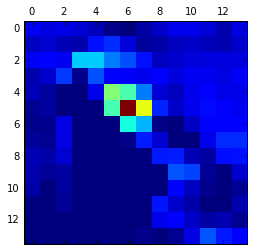

In [39]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [70]:
import cv2

# load image with cv2
img = cv2.imread(img_path) 

# resize heatmap to be same size as image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# converts heamap to rgb
heatmap = np.uint8(255 * heatmap)

# applies heatmap to original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * .5 + img 

# save image to disk
cv2.imwrite('./output_images/dog.jpg', superimposed_img)

True

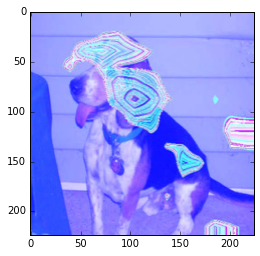

In [72]:
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np


img_path = "./output_images/dog.jpg"
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

plt.imshow(x/255.)

# Voila, very doggy

Chapter summary
1. Convnets are the best tool for attacking visual-classification problems.
2. Convnets work by learning a hierarchy of modular patterns and concepts
to represent the visual world.
3. The representations they learn are easy to inspect—convnets are the opposite of black boxes!
4. You’re now capable of training your own convnet from scratch to solve an image-classification problem.
5. You understand how to use visual data augmentation to fight overfitting.
6. You know how to use a pretrained convnet to do feature extraction and
fine-tuning.
7. You can generate visualizations of the filters learned by your convnets, as well as heatmaps of class activity.